In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import concurrent.futures
import pickle
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [11]:
# Utility Functions
def is_image_file(filename):
    """Check if a file is an image based on its extension."""
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def extract_features(img_path, model):
    """Extract features from an image using the EfficientNetB0 model."""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features


In [12]:
# Feature Processing
def process_image(img_path, model):
    return img_path, extract_features(img_path, model)

In [13]:
# Feature Extraction from Dataset
def extract_features_from_dataset(directory, model, cache_path='features_cache_task2.pkl'):
    """Extract features from all images in the dataset."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            image_paths, features_list = pickle.load(f)
    else:
        image_paths = []
        features_list = []
        img_paths = []
        for subdir, dirs, files in os.walk(directory):
            for file in files:
                if is_image_file(file):
                    img_paths.append(os.path.join(subdir, file))

        print(f"Total images found: {len(img_paths)}")
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(lambda p: process_image(p, model), img_paths))
        
        print(f"Features extracted for {len(results)} images")
        
        for img_path, features in results:
            image_paths.append(img_path)
            features_list.append(features)

        with open(cache_path, 'wb') as f:
            pickle.dump((image_paths, features_list), f)
    
    print(f"Total images processed: {len(image_paths)}")
    return image_paths, features_list

In [14]:
# Image Recommendation
def recommend_similar_images(features, all_features, all_paths, n=10):
    """Recommend n similar images based on feature similarity."""
    neighbors = NearestNeighbors(n_neighbors=n, metric='euclidean')
    all_features = np.array(all_features)
    neighbors.fit(all_features)
    features = np.array(features).reshape(1, -1)
    distances, indices = neighbors.kneighbors(features)
    recommended_images = [all_paths[idx] for idx in indices.flatten()]
    similarity_scores = distances.flatten()
    print(f"Top {n} similar images found with similarity scores: {similarity_scores}")
    return recommended_images, similarity_scores


In [15]:
# Display Functions
def display_images(image_paths):
    """Display images in a grid."""
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(2, 5, i + 1)  # Adjust the grid size depending on how many images you want to show
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path))
    plt.show()

In [16]:
# New function to recommend similar images for an input image
def recommend_similar_images_for_input_image(input_image_path, model, all_features, all_paths, n=10):
    """Recommend n similar images for an input image based on feature similarity."""
    input_image_features = extract_features(input_image_path, model)
    recommended_images, similarity_scores = recommend_similar_images(input_image_features, all_features, all_paths, n)
    print(f"Similar images for {input_image_path}:")
    display_images(recommended_images)
    return recommended_images, similarity_scores

Total images processed: 201
Top 10 similar images found with similarity scores: [0.         0.16377824 0.83256521 0.86195026 0.89008352 0.90459818
 0.91366536 0.92069589 0.92357682 0.92986825]


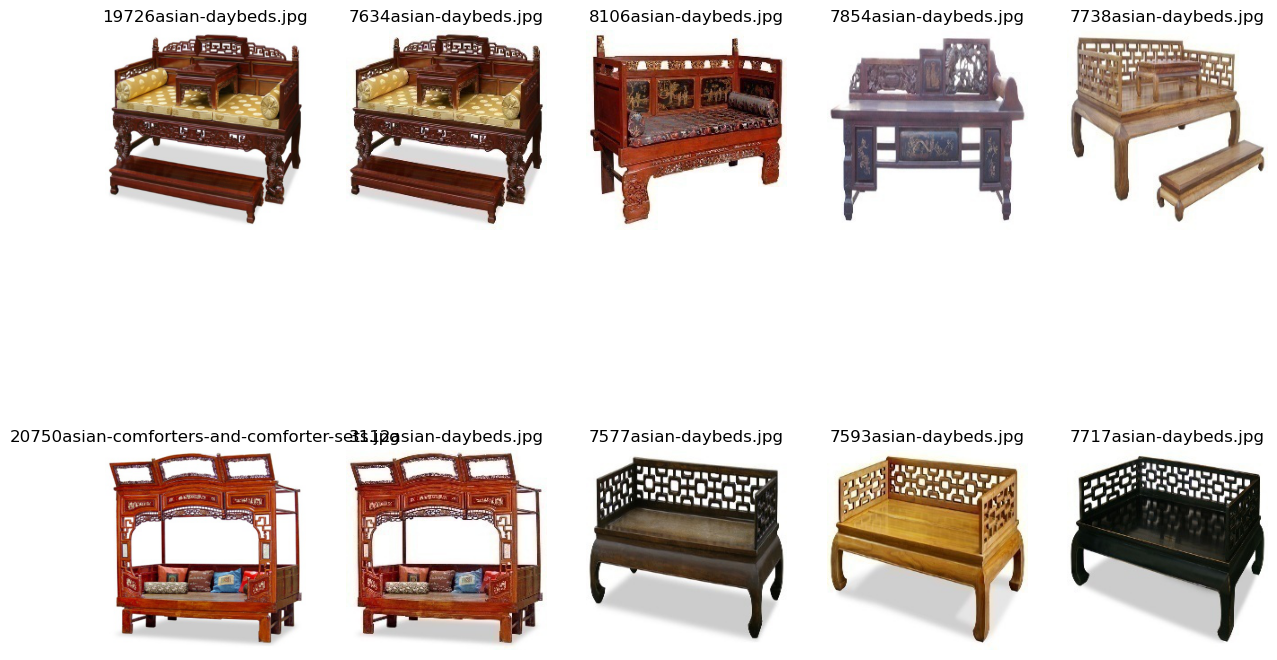

In [17]:
# Main Execution Block
if __name__ == "__main__":
    # Initialize the model
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

    # Dataset direction:
    directory = 'test'  # Replace with your dataset path
    image_paths, features_list = extract_features_from_dataset(directory, model)
    
    # Input image path for finding similar images
    input_image_path = 'test-pic.jpg'

    # Select a feature for a specific image (for example, the first image in the dataset)
    test_image_path = image_paths[0]
    test_image_features = features_list[0]

    # Recommend similar images
    recommended_images, similarity_scores = recommend_similar_images(test_image_features, features_list, image_paths)

    # Display recommended images
    display_images(recommended_images)